<a href="https://colab.research.google.com/github/mohamedshouaib/iti/blob/main/ML_Project/Colab_Project/Hand_Gesture_Classification_project_colab_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# Install required packages
!pip install mediapipe opencv-python-headless scikit-learn numpy pandas

In [6]:
# Import required libraries
import cv2
import numpy as np
import mediapipe as mp
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import deque
from google.colab import drive
import time

# Mount Google Drive for data access
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# Initialize MediaPipe Hands module
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

class HandGestureRecognizer:
    """
    A hand gesture recognition system using classical machine learning algorithms.
    This class handles data loading, preprocessing, model training, and video processing.
    """

    def __init__(self):
        """Initialize the recognizer with empty models and preprocessing objects"""
        self.models = {}  # Dictionary to store trained models
        self.results = {}  # Dictionary to store evaluation results
        self.label_encoder = LabelEncoder()  # For converting string labels to numbers
        self.scaler = StandardScaler()  # For feature standardization
        self.best_model = None  # Will store the best performing model
        self.hand_connections = mp_hands.HAND_CONNECTIONS  # Hand landmark connections

    def load_data(self, csv_path):
        """
        Load and analyze the hand landmarks dataset from a CSV file.

        Args:
            csv_path (str): Path to the CSV file containing the dataset

        Returns:
            pd.DataFrame: Loaded dataset
        """
        print("Loading dataset...")
        data = pd.read_csv(csv_path)
        print(f"Dataset loaded with {len(data)} samples")

        # Display basic dataset information
        print("\n=== Dataset Information ===")
        print("First 5 samples:")
        print(data.head())

        print("\nData types and missing values:")
        print(data.info())

        # Analyze class distribution
        print("\nClass distribution:")
        class_dist = data['label'].value_counts()
        print(class_dist)

        return data

    def visualize_landmarks(self, df, num_samples=3):
        """
        Visualize hand landmarks for random samples from each class.

        Args:
            df (pd.DataFrame): The dataset containing landmark coordinates
            num_samples (int): Number of samples to visualize per class
        """
        print("\nVisualizing hand landmarks...")

        # Get unique gesture classes
        unique_gestures = df['label'].unique()

        # Create figure for visualization
        plt.figure(figsize=(15, 5 * len(unique_gestures[:num_samples])))
        plt.suptitle('Hand Landmark Visualizations', fontsize=16)

        for i, gesture in enumerate(unique_gestures[:num_samples]):
            # Get a sample of the current gesture
            sample = df[df['label'] == gesture].sample(1)
            landmarks = sample.iloc[:, :-1].values.reshape(21, 3)

            # Create 2D plot
            ax = plt.subplot(len(unique_gestures[:num_samples]), 2, 2*i+1)
            ax.scatter(landmarks[:, 0], landmarks[:, 1], c=range(21), cmap='viridis')
            ax.set_title(f'2D: {gesture}')
            ax.invert_yaxis()  # Match image coordinate system

            # Draw connections between landmarks
            for connection in self.hand_connections:
                start_idx, end_idx = connection
                ax.plot([landmarks[start_idx, 0], landmarks[end_idx, 0]],
                        [landmarks[start_idx, 1], landmarks[end_idx, 1]], 'k-')

            # Create 3D plot
            ax = plt.subplot(len(unique_gestures[:num_samples]), 2, 2*i+2, projection='3d')
            ax.scatter(landmarks[:, 0], landmarks[:, 1], landmarks[:, 2],
                      c=range(21), cmap='viridis')
            ax.set_title(f'3D: {gesture}')

            # Draw connections in 3D
            for connection in self.hand_connections:
                start_idx, end_idx = connection
                ax.plot([landmarks[start_idx, 0], landmarks[end_idx, 0]],
                        [landmarks[start_idx, 1], landmarks[end_idx, 1]],
                        [landmarks[start_idx, 2], landmarks[end_idx, 2]], 'k-')

        plt.tight_layout()
        plt.savefig('landmarks_visualization.png')
        plt.show()

    def preprocess_data(self, df):
        """
        Preprocess the hand landmark data for machine learning.

        Args:
            df (pd.DataFrame): Raw dataset with landmark coordinates

        Returns:
            tuple: (processed_features, numeric_labels)
        """
        print("\nPreprocessing data...")

        # Extract features and labels
        X = df.iloc[:, :-1].values  # All columns except last
        y = df.iloc[:, -1].values   # Last column (labels)

        # Encode string labels to numeric values
        y_numeric = self.label_encoder.fit_transform(y)

        # Process each sample to create enhanced features
        processed_features = []
        for landmarks in X.reshape(-1, 21, 3):
            # 1. Center landmarks at wrist (landmark 0)
            wrist = landmarks[0]
            centered = landmarks - wrist

            # 2. Scale by palm size (distance between wrist and middle finger base)
            mid_finger_base = landmarks[9]
            scale = np.linalg.norm(mid_finger_base - wrist)
            if scale > 0:
                centered /= scale

            # 3. Calculate additional geometric features
            # Finger lengths (tip to base for each finger)
            finger_tips = [4, 8, 12, 16, 20]  # Tips of each finger
            finger_lengths = []
            for tip in finger_tips:
                length = np.linalg.norm(centered[tip] - centered[tip-3])
                finger_lengths.append(length)

            # Angles between finger vectors
            vectors = [
                centered[8] - centered[5],   # Index finger vector
                centered[12] - centered[9],  # Middle finger vector
                centered[16] - centered[13], # Ring finger vector
                centered[20] - centered[17]  # Pinky finger vector
            ]

            angles = []
            for i in range(len(vectors)):
                for j in range(i+1, len(vectors)):
                    # Calculate angle between vectors
                    cos_angle = np.dot(vectors[i], vectors[j]) / (
                        np.linalg.norm(vectors[i]) * np.linalg.norm(vectors[j]))
                    angle = np.arccos(np.clip(cos_angle, -1, 1))
                    angles.append(angle)

            # Combine all features (original + engineered)
            combined_features = np.concatenate([
                centered.flatten(),    # Original centered coordinates
                np.array(finger_lengths),  # Finger lengths
                np.array(angles)       # Angles between fingers
            ])

            processed_features.append(combined_features)

        # Convert to numpy array
        X_processed = np.array(processed_features)

        # Standardize features (important for SVM)
        X_processed = self.scaler.fit_transform(X_processed)

        return X_processed, y_numeric

    def train_and_evaluate_models(self, X, y):
        """
        Train and evaluate multiple machine learning models with hyperparameter tuning.

        Args:
            X (np.array): Processed feature matrix
            y (np.array): Numeric labels
        """
        print("\nTraining and evaluating models...")

        # Split data into training and test sets (stratified)
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y)

        # Define models and their parameter grids for tuning
        model_params = {
            "Random Forest": {
                'model': RandomForestClassifier(random_state=42),
                'params': {
                    'n_estimators': [100, 200],
                    'max_depth': [None, 10, 20],
                    'min_samples_split': [2, 5]
                }
            },
            "SVM": {
                'model': SVC(random_state=42, probability=True),
                'params': {
                    'C': [0.1, 1, 10],
                    'kernel': ['rbf', 'poly'],
                    'gamma': ['scale', 'auto']
                }
            },
            "XGBoost": {
                'model': xgb.XGBClassifier(
                    objective='multi:softmax',
                    num_class=len(self.label_encoder.classes_),
                    random_state=42,
                    eval_metric='mlogloss'),
                'params': {
                    'n_estimators': [100, 200],
                    'learning_rate': [0.01, 0.1],
                    'max_depth': [3, 6]
                }
            }
        }

        # Train and tune each model
        for name, mp in model_params.items():
            print(f"\n=== Training {name} ===")

            # Use stratified K-fold for cross-validation
            cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

            # Grid search for hyperparameter tuning
            grid = GridSearchCV(
                mp['model'],
                mp['params'],
                cv=cv,
                scoring='accuracy',
                n_jobs=-1,
                verbose=1
            )

            # Time the training process
            start_time = time.time()
            grid.fit(X_train, y_train)
            training_time = time.time() - start_time

            # Store best model
            self.models[name] = grid.best_estimator_

            # Evaluate on test set
            y_pred = self.models[name].predict(X_test)
            y_pred_labels = self.label_encoder.inverse_transform(y_pred)
            y_test_labels = self.label_encoder.inverse_transform(y_test)

            # Store results including confusion matrix
            self.results[name] = {
                'accuracy': accuracy_score(y_test_labels, y_pred_labels),
                'report': classification_report(y_test_labels, y_pred_labels, output_dict=True),
                'confusion_matrix': confusion_matrix(y_test_labels, y_pred_labels),
                'training_time': training_time,
                'best_params': grid.best_params_
            }

            # Print results
            print(f"\nBest parameters for {name}: {grid.best_params_}")
            print(f"Training time: {training_time:.2f} seconds")
            print(f"Test accuracy: {self.results[name]['accuracy']:.3f}")
            print(classification_report(y_test_labels, y_pred_labels))

            # Plot confusion matrix
            plt.figure(figsize=(8, 6))
            sns.heatmap(self.results[name]['confusion_matrix'],
                        annot=True, fmt='d',
                        xticklabels=self.label_encoder.classes_,
                        yticklabels=self.label_encoder.classes_)
            plt.title(f'Confusion Matrix - {name}')
            plt.ylabel('True Label')
            plt.xlabel('Predicted Label')
            plt.tight_layout()
            plt.savefig(f'confusion_matrix_{name}.png')
            plt.show()

        # Select best model based on test accuracy
        best_model_name = max(self.results.items(), key=lambda x: x[1]['accuracy'])[0]
        self.best_model = self.models[best_model_name]

        print(f"\nBest model selected: {best_model_name} with accuracy {self.results[best_model_name]['accuracy']:.3f}")

    def process_video(self, input_path, output_path):
        """
        Process an input video to detect hand gestures and save the output.

        Args:
            input_path (str): Path to input video file
            output_path (str): Path to save output video
        """
        print(f"\nProcessing video: {input_path}")

        # Initialize MediaPipe Hands
        hands = mp_hands.Hands(
            static_image_mode=False,
            max_num_hands=1,
            min_detection_confidence=0.7,
            min_tracking_confidence=0.5
        )

        # Open input video
        cap = cv2.VideoCapture(input_path)
        if not cap.isOpened():
            print("Error: Could not open video file")
            return

        # Get video properties
        frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fps = cap.get(cv2.CAP_PROP_FPS)

        # Create video writer for output
        fourcc = cv2.VideoWriter_fourcc(*'XVID')
        out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

        # For prediction stabilization
        prediction_history = deque(maxlen=5)

        frame_count = 0
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            frame_count += 1
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            results = hands.process(frame_rgb)

            if results.multi_hand_landmarks:
                for hand_landmarks in results.multi_hand_landmarks:
                    # Extract landmarks and preprocess exactly like training data
                    landmarks = np.array([[lm.x, lm.y, lm.z] for lm in hand_landmarks.landmark])

                    # 1. Center at wrist
                    wrist = landmarks[0]
                    centered = landmarks - wrist

                    # 2. Scale by palm size
                    mid_finger_base = landmarks[9]
                    scale = np.linalg.norm(mid_finger_base - wrist)
                    if scale > 0:
                        centered /= scale

                    # 3. Calculate additional features (same as training)
                    finger_tips = [4, 8, 12, 16, 20]
                    finger_lengths = []
                    for tip in finger_tips:
                        length = np.linalg.norm(centered[tip] - centered[tip-3])
                        finger_lengths.append(length)

                    vectors = [
                        centered[8] - centered[5],   # Index finger
                        centered[12] - centered[9],  # Middle finger
                        centered[16] - centered[13], # Ring finger
                        centered[20] - centered[17]  # Pinky finger
                    ]

                    angles = []
                    for i in range(len(vectors)):
                        for j in range(i+1, len(vectors)):
                            cos_angle = np.dot(vectors[i], vectors[j]) / (
                                np.linalg.norm(vectors[i]) * np.linalg.norm(vectors[j]))
                            angle = np.arccos(np.clip(cos_angle, -1, 1))
                            angles.append(angle)

                    # Combine all features
                    features = np.concatenate([
                        centered.flatten(),
                        np.array(finger_lengths),
                        np.array(angles)
                    ]).reshape(1, -1)

                    # Standardize features
                    features = self.scaler.transform(features)

                    # Predict gesture
                    all_predictions = []
                    for model in self.models.values():
                        if hasattr(model, 'predict_proba'):
                            proba = model.predict_proba(features)[0]
                            all_predictions.append(proba)
                        else:
                            pred = model.predict(features)[0]
                            one_hot = np.eye(len(self.label_encoder.classes_))[pred]
                            all_predictions.append(one_hot)

                    final_proba = np.mean(all_predictions, axis=0)
                    pred_class = np.argmax(final_proba)
                    confidence = np.max(final_proba)
                    pred_label = self.label_encoder.inverse_transform([pred_class])[0]

                    # Update prediction history for stabilization
                    prediction_history.append(pred_label)

                    # Use mode of recent predictions for stabilization
                    if len(prediction_history) > 0:
                        stabilized_pred = max(set(prediction_history),
                                            key=prediction_history.count)
                    else:
                        stabilized_pred = pred_label

                    # Draw landmarks and prediction
                    mp_drawing.draw_landmarks(
                        frame, hand_landmarks, self.hand_connections)

                    # Display prediction with confidence
                    text = f"Gesture: {stabilized_pred}"
                    cv2.putText(frame, text, (20, 50),
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

            # Write frame to output video
            out.write(frame)

        # Release resources
        cap.release()
        out.release()
        hands.close()
        print(f"Finished processing")
        print(f"Output video saved to: {output_path}")


=== Starting Hand Gesture Recognition Pipeline ===

[Step 1/5] Loading and analyzing data...
Loading dataset...
Dataset loaded with 25675 samples

=== Dataset Information ===
First 5 samples:
           x1          y1            z1          x2          y2        z2  \
0  262.669968  257.304901 -3.649205e-07  257.417542  247.109055  0.004224   
1   83.351778  346.059113 -2.345265e-07   81.925037  328.562347 -0.011102   
2  187.756977  260.235492 -2.417307e-07  195.460579  241.506035 -0.000184   
3  114.976696  331.594238 -1.233261e-07  114.503494  320.549957 -0.002824   
4  188.795288  141.727867 -1.622995e-07  188.520905  127.947464 -0.002884   

           x3          y3        z3          x4  ...         x19         y19  \
0  246.882957  241.716827  0.005798  236.384537  ...  223.345093  255.490692   
1   90.080132  311.535248 -0.021096   95.641823  ...  132.451618  341.794434   
2  207.259529  223.674339 -0.009687  215.413628  ...  250.301010  268.602938   
3  116.636627  310.080994

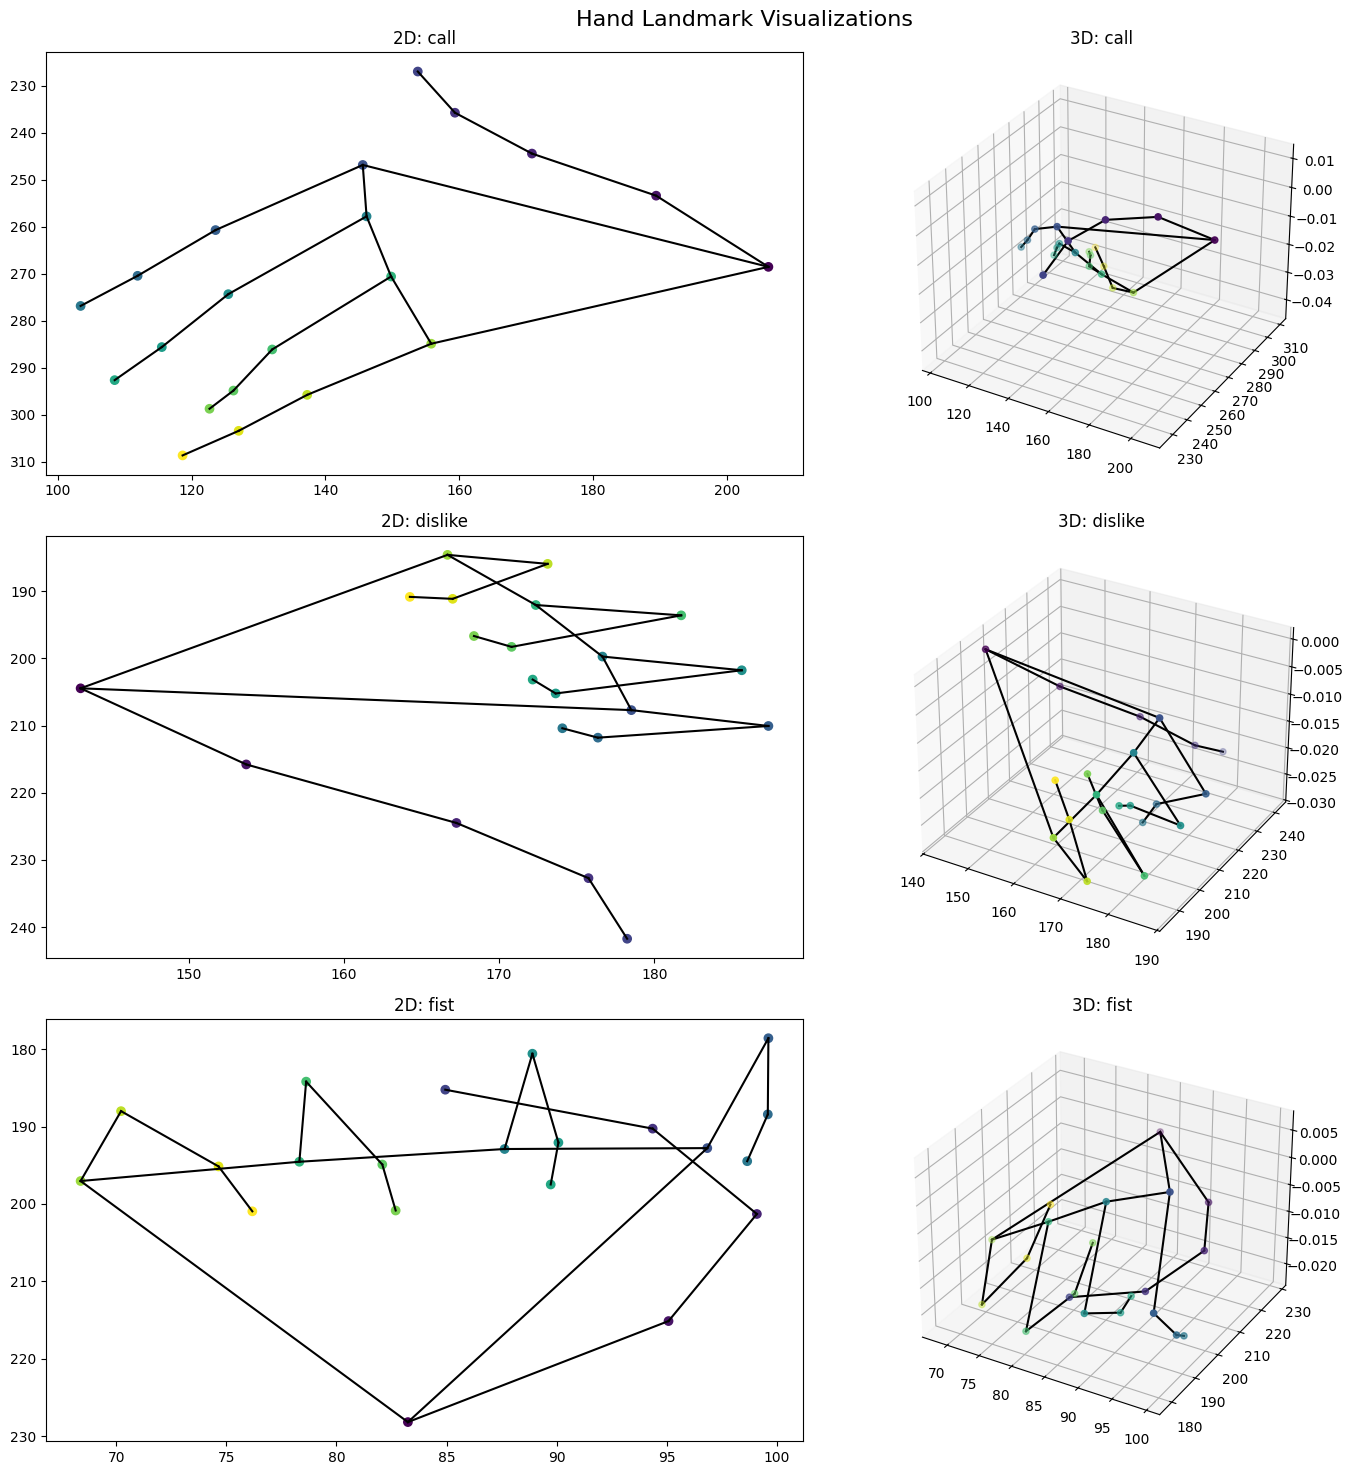


[Step 3/5] Preprocessing data...

Preprocessing data...

[Step 4/5] Training and evaluating models...

Training and evaluating models...

=== Training Random Forest ===
Fitting 3 folds for each of 12 candidates, totalling 36 fits

Best parameters for Random Forest: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200}
Training time: 664.56 seconds
Test accuracy: 0.985
                 precision    recall  f1-score   support

           call       0.99      0.99      0.99       301
        dislike       1.00      1.00      1.00       259
           fist       1.00      0.99      1.00       189
           four       0.98      0.98      0.98       327
           like       0.99      0.99      0.99       287
           mute       0.96      0.98      0.97       217
             ok       1.00      0.99      0.99       318
            one       0.96      0.96      0.96       253
           palm       0.97      0.98      0.98       330
          peace       0.99      0.98      0.98  

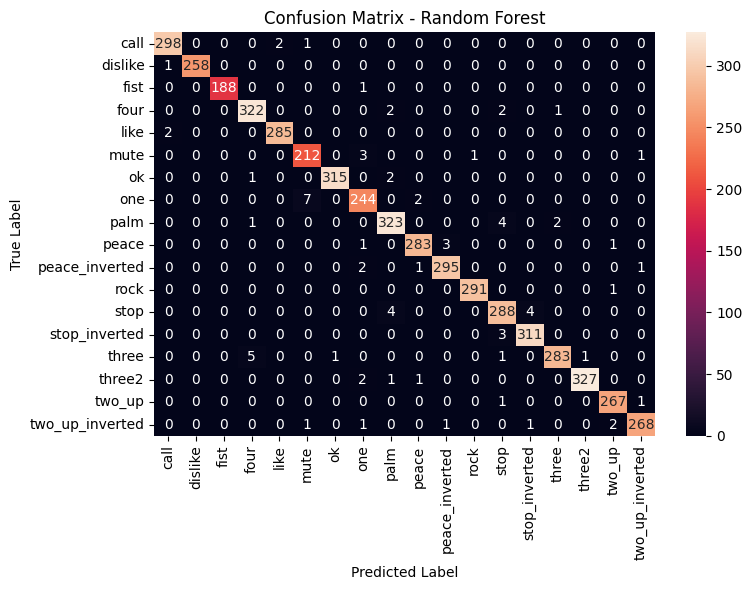


=== Training SVM ===
Fitting 3 folds for each of 12 candidates, totalling 36 fits

Best parameters for SVM: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Training time: 780.06 seconds
Test accuracy: 0.988
                 precision    recall  f1-score   support

           call       1.00      0.99      0.99       301
        dislike       1.00      1.00      1.00       259
           fist       1.00      0.99      1.00       189
           four       0.98      0.99      0.98       327
           like       0.99      1.00      0.99       287
           mute       0.96      0.98      0.97       217
             ok       1.00      0.98      0.99       318
            one       0.97      0.97      0.97       253
           palm       0.98      0.99      0.98       330
          peace       0.99      0.99      0.99       288
 peace_inverted       0.99      0.99      0.99       299
           rock       1.00      0.99      0.99       292
           stop       0.97      0.98      0.97       2

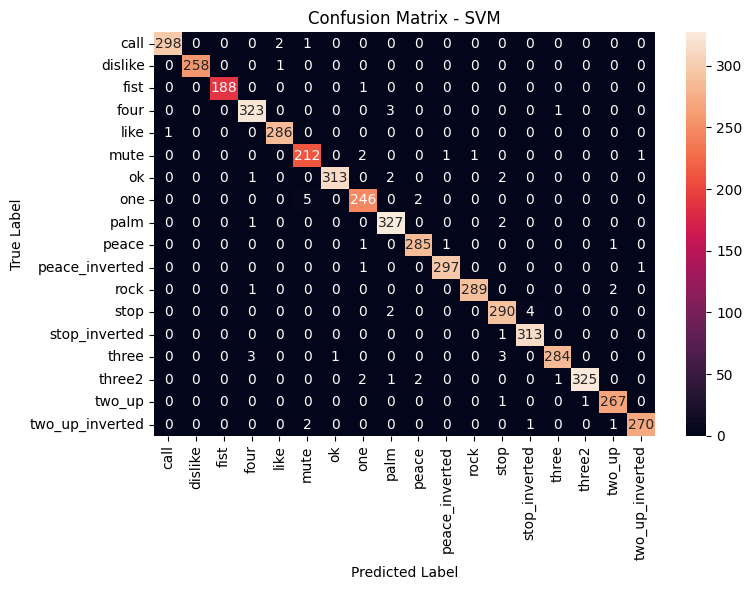


=== Training XGBoost ===
Fitting 3 folds for each of 8 candidates, totalling 24 fits

Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Training time: 554.52 seconds
Test accuracy: 0.987
                 precision    recall  f1-score   support

           call       0.99      0.99      0.99       301
        dislike       1.00      1.00      1.00       259
           fist       0.99      0.99      0.99       189
           four       0.99      0.98      0.98       327
           like       0.99      0.99      0.99       287
           mute       0.96      0.97      0.97       217
             ok       1.00      1.00      1.00       318
            one       0.96      0.97      0.96       253
           palm       0.97      0.99      0.98       330
          peace       0.98      1.00      0.99       288
 peace_inverted       0.99      0.98      0.98       299
           rock       1.00      1.00      1.00       292
           stop       0.98     

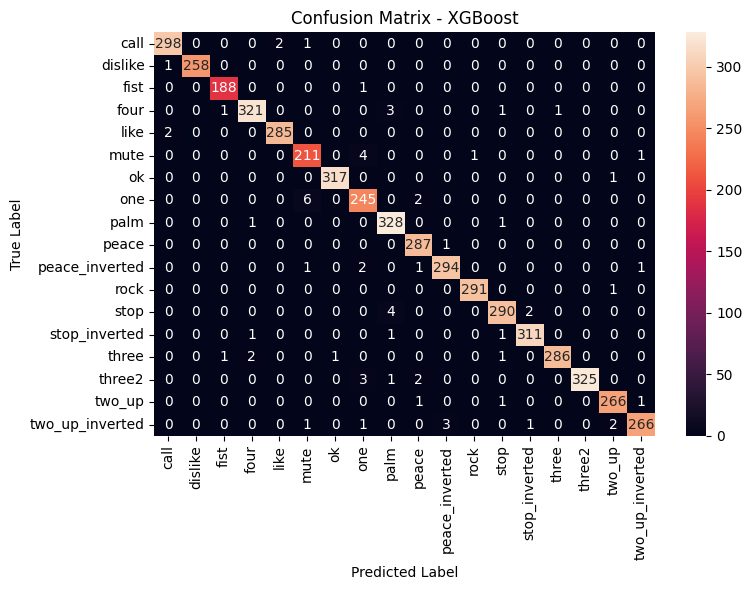


Best model selected: SVM with accuracy 0.988

[Step 5/5] Processing video...

Processing video: /content/drive/My Drive/ML_Project/input.mp4
Finished processing
Output video saved to: /content/drive/My Drive/ML_Project/output_video.avi

=== Pipeline Completed Successfully ===


In [8]:
def main():
    """Main function to execute the hand gesture recognition pipeline"""
    try:
        # Initialize recognizer
        recognizer = HandGestureRecognizer()

        # Define file paths (modify these as needed)
        csv_path = '/content/drive/My Drive/ML_Project/hand_landmarks_data.csv'
        input_video_path = '/content/drive/My Drive/ML_Project/input.mp4'
        output_video_path = '/content/drive/My Drive/ML_Project/output_video.avi'

        # Execute pipeline steps
        print("=== Starting Hand Gesture Recognition Pipeline ===")

        # 1. Load and analyze data
        print("\n[Step 1/5] Loading and analyzing data...")
        data = recognizer.load_data(csv_path)

        # 2. Visualize data
        print("\n[Step 2/5] Visualizing hand landmarks...")
        recognizer.visualize_landmarks(data)

        # 3. Preprocess data
        print("\n[Step 3/5] Preprocessing data...")
        X, y = recognizer.preprocess_data(data)

        # 4. Train and evaluate models
        print("\n[Step 4/5] Training and evaluating models...")
        recognizer.train_and_evaluate_models(X, y)

        # 5. Process video
        print("\n[Step 5/5] Processing video...")
        recognizer.process_video(input_video_path, output_video_path)

        print("\n=== Pipeline Completed Successfully ===")

    except Exception as e:
        print(f"\n!!! Pipeline Failed !!!")
        print(f"Error: {str(e)}")

if __name__ == "__main__":
    main()